# Description

* This is a synthetic dataset created for a college project. This data aims to predict whether students will continue to go to college or not. With machine learning explainability, school counselors can help students that will not go to college by finding the factor and helping them. There are 1000 samples with 10 features in each.

### Look at the dataset
1. The dataset is in .csv format.
2. Features are: type_school,	school_accreditation,	gender,	interest,	residence,	parent_age,	parent_salary,	house_area,	average_grades,	parent_was_in_college.
3. I do not see any problems.

### Question 1: What is the most correlated feature with going to a college?

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression

filepath = 'go to college dataset/data.csv'

In [14]:
data = pd.read_csv(filepath)
data.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [15]:
# Separate target from predictors
X = data.drop('will_go_to_college', axis = 1)
y = data['will_go_to_college']

## Interest vs reality

Text(0.5, 1.0, 'interest vs reality')

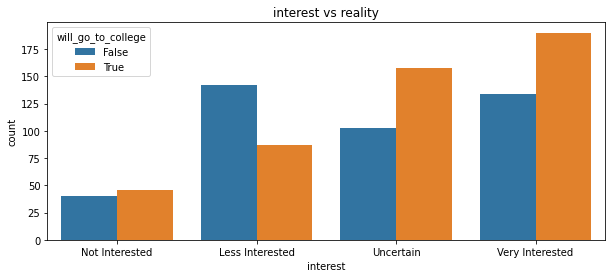

In [18]:
plt.figure(figsize=(10,4))
sns.countplot(data=data, x='interest', hue='will_go_to_college', order=['Not Interested','Less Interested', 'Uncertain', 'Very Interested'])
plt.title('interest vs reality')

* Interest is not linearly correlated with college admission.
* There are students who were quite interested to go to college, but did not go.
* There are students who were not interested to go to college but still went to college.

In [20]:
num_cols = list(data.select_dtypes(exclude= ['object','bool']).columns)
pd.pivot_table(data, index = 'interest', values = num_cols)

,average_grades,house_area,parent_age,parent_salary
interest,,,,
Interested,84.970500,60.007000,53.730000,4.897400e+06
Less Interested,85.199913,71.824454,53.039301,5.116987e+06
Not Interested,86.603488,77.375581,51.093023,5.286512e+06
Uncertain,87.125517,78.594253,51.567050,5.609195e+06
Very Interested,86.116389,76.850000,51.962963,5.559877e+06


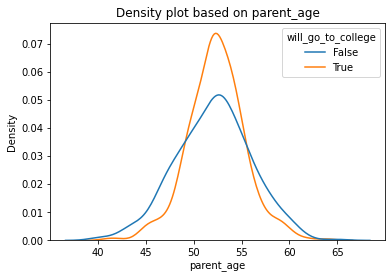

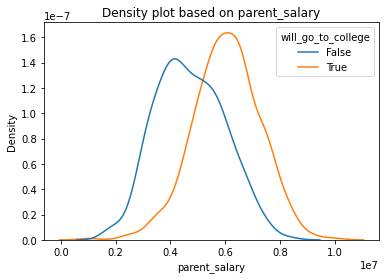

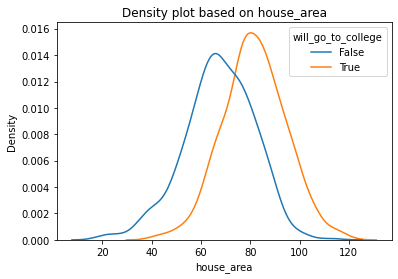

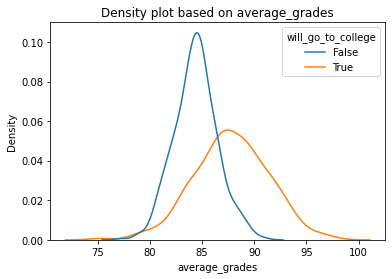

In [23]:
def numerical_plot(cols):
    sns.kdeplot(data = data, x=cols, hue='will_go_to_college')
    plt.title('Density plot based on '+cols)
    plt.show()
    
for cols in num_cols:
    numerical_plot(cols)

### Conclusion:

* Higher parent salary -> higher chance to go to college.
* Larger house area -> higher chance to go to college. It might correlated with parent salary.
* Higher average grades -> higher chance to go to college. Grade 93 ++ all go to college.

<AxesSubplot:>

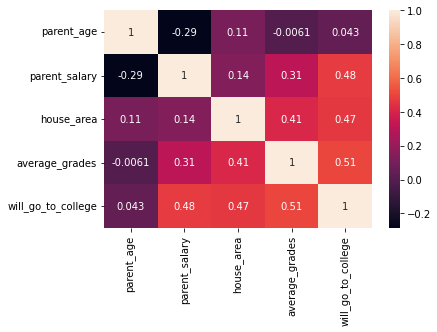

In [26]:
# Correlation

sns.heatmap(data=data[num_cols+['will_go_to_college']].corr(), annot=True)

### Conclusion

* House area is not correlated significantly with parent salary.
* Average grade seems to be the most correlated feature to will_go_to_college.

In [27]:
from sklearn.model_selection import train_test_split

# Separate target from predictors
X = data.drop('will_go_to_college', axis = 1)
y = data['will_go_to_college']

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [53]:
# use most correlated features
X_train = X_train_full[['average_grades', 'parent_salary']].copy()
X_valid = X_valid_full[['average_grades', 'parent_salary']].copy()

In [54]:
from sklearn.preprocessing import OneHotEncoder

y_train2 = [int(y) for y in y_train]
y_valid2 = [int(y) for y in y_valid]

### Linear Regression
* Although this is a binary classification problem, linear regression can be applied by setting a threshold on scalar output values (e.g. 0.5)

In [55]:
from sklearn.metrics import classification_report

lr = LinearRegression()
lr.fit(X_train, y_train2)
y_pred = lr.predict(X_valid)
print(classification_report(y_valid2, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       106
           1       0.79      0.79      0.79        94

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



## Hypothesis 2: Interest is more important than average grades.

In [178]:
from collections import Counter
Counter(X_train['interest'])

Counter({'Uncertain': 217,
         'Very Interested': 257,
         'Not Interested': 65,
         'Less Interested': 180,
         'Interested': 81})

In [213]:
X_train = X_train_full[['interest', 'parent_salary']].copy()
X_valid = X_valid_full[['interest', 'parent_salary']].copy()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

interest_enc = OrdinalEncoder(categories=[np.array(['Not Interested','Less Interested', 'Uncertain',
                                                    'Interested', 'Very Interested'])])
ordinal_cols = ['interest']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', interest_enc, ordinal_cols)
    ])
col_name = X_train.columns
X_train = pd.DataFrame(preprocessor.fit_transform(X_train[['interest']])).join(X_train_full[['parent_salary']]*1e-3)
X_valid = pd.DataFrame(preprocessor.fit_transform(X_valid[['interest']])).join(X_valid_full[['parent_salary']]*1e-3)
# for i in range(len(X_train)):
#     print(i, '. ', X_train.iloc[i])
X_train['parent_salary'].fillna(value=X_train['parent_salary'].mean(), inplace=True)
X_valid['parent_salary'].fillna(value=X_valid['parent_salary'].mean(), inplace=True)

X_train.columns = col_name
X_valid.columns = col_name
X_train.head()

,interest,parent_salary
0,2.0,6950.0
1,4.0,4410.0
2,4.0,6500.0
3,0.0,6600.0
4,2.0,5250.0


In [214]:
lr = LinearRegression()
lr.fit(X_train, y_train2)
y_pred = lr.predict(X_valid)
print(classification_report(y_valid2, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       106
           1       0.49      0.48      0.48        94

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



* Apparently interest is less important than average grades since all the prediction performance metrics are worse. 